In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit.aqua import QuantumInstance
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import pylab
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms import VQE
from qiskit.circuit.library import TwoLocal
import numpy as np

In [2]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

backend = Aer.get_backend("qasm_simulator") 
print(backend)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


qasm_simulator


In [3]:
#Set the seed for reproducible results
aqua_globals.random_seed = 100
seed_simulator = 100
seed_transpiler=100
np.random.seed(100)

In [4]:
molecule = Molecule(geometry=[['H', [0., 0., 0.]],['H', [0., 0., 0.735]]],charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
transformation = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER)

In [5]:
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [6]:
numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(transformation, numpy_solver)
res = calc.solve(driver)
energy = res.groundenergy + 0.719968994449
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.0]  Total: 0.
 


In [7]:
quantum_instance = QuantumInstance(backend=backend,seed_simulator=seed_simulator, seed_transpiler=seed_transpiler) 
num_qubits = 4
var_forms = [('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)]),
             ('RY_CZ', 'ry', 'cz', [(2, 3), (1, 2), (0, 1), (0, 3)]),
             ('HRX_CX', ['h', 'rx'], 'cx', 'full'),
             ('HRX_CZ', ['h', 'rx'], 'cz', 'full'),
             ('RYRZ_CZ', ['ry', 'rz'], 'cz','full'),
             ('RYRZ_CX', ['ry', 'rz'], 'cx', 'full')]

# CX or CZ circuit experiment
for k in range(len(var_forms)):
    print(var_forms[k])
    tl_circuit = TwoLocal(num_qubits, var_forms[k][1], var_forms[k][2], reps=1, entanglement=var_forms[k][3], insert_barriers=True)
    optimizer = SPSA(maxiter=200)
    vqe_solver = VQE(var_form = tl_circuit, quantum_instance = quantum_instance, optimizer= optimizer, callback=store_intermediate_result) 
    calc = GroundStateEigensolver(transformation, vqe_solver)
    result = calc.solve(driver)
    ground_energy = result.groundenergy + 0.719968994449
    energy_diff = ground_energy -energy
    print('result:', ground_energy)
    print('Energy difference:', energy_diff)
    print(result)

('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
result: -1.1192874650284117
Energy difference: 0.01801857072497204
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.839256459477
  - computed part:      -1.839256459477
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.119287465028
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 1.999 S: 0.002 S^2: 0.002 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.46234178]
    - computed part:      [0.0  0.0  1.46234178]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  -0.07339308]  Total: 0.07339308
                 (debye): [0.0  0.0  -0.18654658]  Total: 0.18654658
 
('RY_CZ', 'ry', 'cz', [(2, 3), (1, 2), (0, 1), (0, 3)])
result: -1.1088541

Text(0.5, 1.0, 'Convergence with no noise')

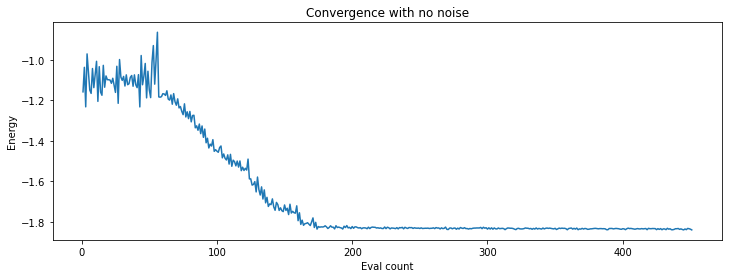

In [85]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')